## Training and Plotting BLISS on DC2 Data

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import numpy as np
from os import environ
from pathlib import Path
from einops import rearrange

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from hydra import initialize, compose
from hydra.utils import instantiate

environ["BLISS_HOME"] = str(Path().resolve().parents[1])

### Train

In [3]:
# %%capture

# with initialize(config_path=".", version_base=None):
#     cfg = compose("train_config")
# from bliss.main import train
# train_config = cfg.copy()

# train(train_config.train)

### Load One Full Image

In [3]:
with initialize(config_path=".", version_base=None):
    cfg = compose("test_config")
    test_config = cfg.copy()

In [4]:
import pickle
with open("out_dc2.pkl", "rb") as inputp: 
    dc2 = pickle.load(inputp)

In [5]:
dc2 = instantiate(test_config.surveys.dc2) # load full dc2 image (without image split)
dc2.prepare_data()

import pickle

with open("out_dc2.pkl", "wb") as outp:  # Overwrites any existing file.
    pickle.dump(dc2, outp, pickle.HIGHEST_PROTOCOL)

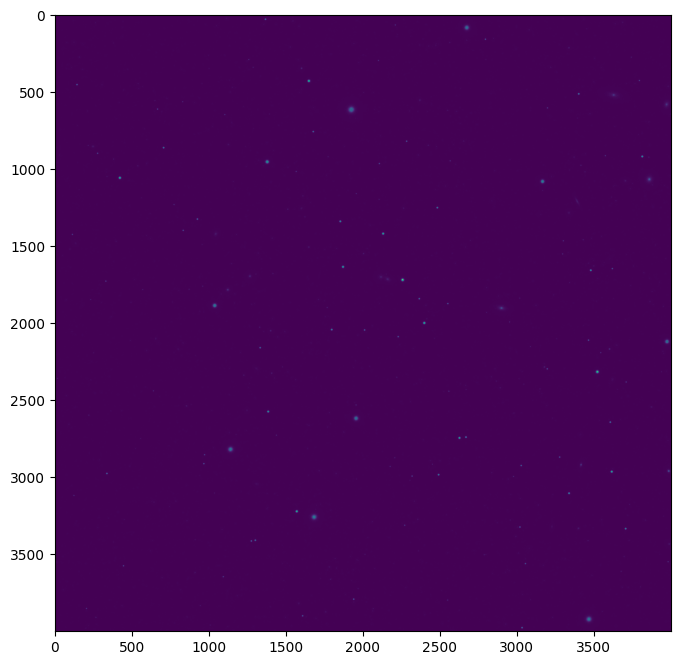

In [5]:
# full image (4000 x 4000)
fig, ax = plt.subplots(figsize=(8, 8))
image = dc2.dc2_data[0]["images"][0]
ax.imshow(np.log((image - image.min()) + 10), cmap="viridis")

### Load LSST Catalogs

In [6]:
import GCRCatalogs
GCRCatalogs.set_root_dir("/data/dc2/")
lsst_catalog = GCRCatalogs.load_catalog("desc_dc2_run2.2i_dr6_object_with_truth_match")
lsst_catalog = lsst_catalog.get_quantities(["id_truth", "objectId", 
                                         "ra", "dec", 
                                         "truth_type", 
                                         "cModelFlux_r", "cModelFluxErr_r"])
lsst_catalog = pd.DataFrame(lsst_catalog)

### Match LSST Catalog with the DC2 image

In [7]:
cur_image_wcs = dc2.dc2_data[0]["wcs"]
cur_image_true_full_catalog = dc2.dc2_data[0]["full_catalog"]

In [8]:
# filter the object in the LSST catalog and keep the object in the current dc2 image
lsst_ra = torch.tensor(lsst_catalog["ra"].values)
lsst_dec = torch.tensor(lsst_catalog["dec"].values)

lsst_pt, lsst_pr = cur_image_wcs.all_world2pix(lsst_ra, lsst_dec, 0)
lsst_pt = torch.tensor(lsst_pt)
lsst_pr = torch.tensor(lsst_pr)
lsst_plocs = torch.stack((lsst_pr, lsst_pt), dim=-1)

x0_mask = (lsst_plocs[:, 0] > 0) & (lsst_plocs[:, 0] < 4000)
x1_mask = (lsst_plocs[:, 1] > 0) & (lsst_plocs[:, 1] < 4000)
x_mask = x0_mask * x1_mask

lsst_catalog["cModelFlux"] = lsst_catalog["cModelFlux_r"] + lsst_catalog["cModelFluxErr_r"]
flux_mask = lsst_catalog["cModelFlux"] > 0

x_and_flux_mask = x_mask * torch.tensor(flux_mask.to_numpy())

lsst_catalog = lsst_catalog.loc[x_and_flux_mask.tolist()]
lsst_catalog["plocs0"] = lsst_plocs[x_and_flux_mask, 0]
lsst_catalog["plocs1"] = lsst_plocs[x_and_flux_mask, 1]

### Load the trained model and make prediction

In [9]:
MODEL_PATH = "/home/pduan/bliss/output/DC2_NEW_MODELS/dc2_psf_da/checkpoints/best_encoder.ckpt"
encoder = instantiate(test_config.encoder)
pretrained_weights = torch.load(MODEL_PATH)["state_dict"]
# pretrained_weights["features_net.preprocess3d.0.weight"] = \
#       pretrained_weights["features_net.preprocess3d.0.weight"][:, :, 0, :, :].unsqueeze(2)
encoder.load_state_dict(pretrained_weights)
encoder.eval();

/home/pduan/bliss/bliss/encoder/image_normalizer.py:39: UserWarning: Either log transform or clahe should be enabled.
  warnings.warn("Either log transform or clahe should be enabled.")


In [12]:
# import pickle
# with open("out_dict.pkl", "rb") as inputp: 
#     out_dict = pickle.load(inputp)

In [15]:
batch = {
    "tile_catalog": dc2.dc2_data[0]['tile_catalog'],
    "images": rearrange(dc2.dc2_data[0]['images'], "h w nw -> 1 h w nw"),
    "background": rearrange(dc2.dc2_data[0]['background'], "h w nw -> 1 h w nw"),
    "psf_params": rearrange(dc2.dc2_data[0]['psf_params'], "h w -> 1 h w")
    }

with torch.no_grad():
    out_dict = encoder.predict_step(batch, None)

import pickle

with open("out_dict.pkl", "wb") as outp:  # Overwrites any existing file.
    pickle.dump(out_dict, outp, pickle.HIGHEST_PROTOCOL)


KeyboardInterrupt: 

In [14]:
# # use this only if you want to create some toy samples
# out_dict["mode_cat"].n_sources = torch.randint_like(
#     out_dict["mode_cat"].to_dict()["n_sources"], 
#     low=0, high=2
#     )

In [13]:
out_dict

{'mode_cat': TileCatalog(1 x 1000 x 1000),
 'sample_cat': TileCatalog(1 x 1000 x 1000)}

In [16]:
# just for testing
# out_dict = cur_image_true_full_catalog

In [12]:
bliss_catalog = out_dict["mode_cat"]
bliss_catalog = bliss_catalog.to_full_catalog()
bliss_catalog.plocs = bliss_catalog.plocs + 4
matcher = instantiate(test_config.encoder.matcher)
metrics = instantiate(test_config.encoder.metrics)
matching = matcher.match_catalogs(dc2.dc2_data[0]["full_catalog"], bliss_catalog)
metric = metrics(dc2.dc2_data[0]["full_catalog"], bliss_catalog, matching)
print(metric["detection_recall"], metric["detection_precision"], 
      metric["detection_f1"], metric["classification_acc"])

tensor(0.) tensor(nan) tensor(nan) nan


In [18]:
# bliss_catalog = out_dict
# matcher = instantiate(test_config.encoder.matcher)
# metrics = instantiate(test_config.encoder.metrics)
# matching = matcher.match_catalogs(cur_image_true_full_catalog, bliss_catalog)
# metric = metrics(cur_image_true_full_catalog, bliss_catalog, matching)
# print(metric["detection_recall"], metric["detection_precision"], 
#       metric["detection_f1"], metric["classification_acc"])

tensor(1.) tensor(1.) tensor(1.) 1.0


### Plotting

In [19]:
# could use macher for bliss catalog and truth catalog
# this function (match_by_locs) is for matching the lsst detection location and truth object location
from einops import rearrange, reduce
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import min_weight_full_bipartite_matching
def match_by_locs(true_locs, est_locs, slack=1.0):
    """Match true and estimated locations and returned indices to match.

    Permutes `est_locs` to find minimal error between `true_locs` and `est_locs`.
    The matching is done with `scipy.optimize.linear_sum_assignment`, which implements
    the Hungarian algorithm.

    Automatically discards matches where at least one location has coordinates **exactly** (0, 0).

    Args:
        slack: Threshold for matching objects a `slack` l-infinity distance away (in pixels).
        true_locs: Tensor of shape `(n1 x 2)`, where `n1` is the true number of sources.
            The centroids should be in units of PIXELS.
        est_locs: Tensor of shape `(n2 x 2)`, where `n2` is the predicted
            number of sources. The centroids should be in units of PIXELS.

    Returns:
        A tuple of the following objects:
        - row_indx: Indicies of true objects matched to estimated objects.
        - col_indx: Indicies of estimated objects matched to true objects.
        - dist_keep: Matched objects to keep based on l1 distances.
        - avg_distance: Average l-infinity distance over all matched objects.
        - avg_keep_distance: Average l-infinity distance over matched objects to keep.
    """
    assert len(true_locs.shape) == len(est_locs.shape) == 2
    assert true_locs.shape[-1] == est_locs.shape[-1] == 2
    assert isinstance(true_locs, torch.Tensor) and isinstance(est_locs, torch.Tensor)

    # reshape
    locs1 = true_locs.view(-1, 2)
    locs2 = est_locs.view(-1, 2)

    locs_abs_diff = (rearrange(locs1, "i j -> i 1 j") - rearrange(locs2, "i j -> 1 i j")).abs()
    locs_err = reduce(locs_abs_diff, "i j k -> i j", "sum")
    locs_err_l_infty = reduce(locs_abs_diff, "i j k -> i j", "max")

    # Penalize all pairs which are greater than slack apart to favor valid matches.
    locs_err = locs_err + (locs_err_l_infty > slack) * locs_err.max()

    # add small constant to avoid 0 weights (required for sparse bipartite matching)
    locs_err += 0.001

    # convert light source error matrix to CSR
    csr_locs_err = csr_matrix(locs_err.detach().cpu())

    # find minimal permutation and return matches
    row_indx, col_indx = min_weight_full_bipartite_matching(csr_locs_err)

    # only match objects that satisfy threshold on l-infinity distance.
    dist = (locs1[row_indx] - locs2[col_indx]).abs().max(1)[0]

    # GOOD match condition: L-infinity distance is less than slack
    dist_keep = (dist < slack).bool()
    avg_distance = dist.mean()
    avg_keep_distance = dist[dist < slack].mean()

    if dist_keep.sum() > 0:
        assert dist[dist_keep].max() <= slack

    return row_indx, col_indx, dist_keep.cpu().numpy(), avg_distance, avg_keep_distance, dist


In [20]:
cur_image_true_full_catalog.to_dict()["galaxy_fluxes"][0, :, 2]

tensor([25556772.0000,   247993.8750,   111257.5312,  2663207.2500,
          273151.5625,   736772.8125,   375381.7188, 86701496.0000,
          436399.6250,   386493.2500,  8663142.0000,  1088802.1250,
         1045923.0625, 10643484.0000,   103263.2188,   374898.7188,
          170779.1562,   580636.4375,  1465297.1250,   136697.0781,
          574901.3750,  4821021.5000,   176906.4219,   160402.0625,
         1340157.2500,   193819.7812,   201631.3594, 14357643.0000,
          184178.0938,   242640.7031,   790513.4375,   106956.6406,
          223467.0625,  4274291.5000,   410724.2188,   113158.0156,
          107933.4219,   103144.0156,   248513.0625, 17015662.0000,
         5737375.0000, 21421638.0000,   862416.3750,   240180.4531,
         1264889.7500,   317111.8125, 27590328.0000,   245133.6094,
          108125.2344,   149825.8906,   403701.7812,  1361848.3750,
          497656.0938,   138515.6250, 36869720.0000,  1754230.5000,
          569743.0625,   109663.8203,   810702.0

(array([62.,  3.,  2.,  1.,  1.,  1.,  0.,  0.,  0.,  1.]),
 array([  103144.015625,  8762979.      , 17422814.      , 26082650.      ,
        34742484.      , 43402320.      , 52062156.      , 60721992.      ,
        69381824.      , 78041664.      , 86701496.      ]),
 <BarContainer object of 10 artists>)

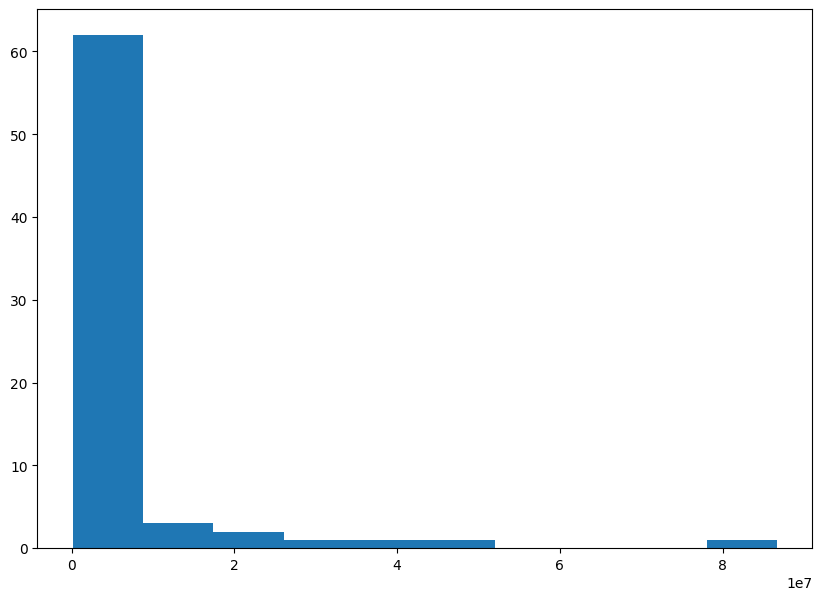

In [21]:
# galaxy flux distribution
fig, ax = plt.subplots(figsize=(10, 7))
ax.hist(cur_image_true_full_catalog.to_dict()["galaxy_fluxes"][0, :, 2])

In [22]:
#compute detection distance
row_bliss, col_bliss, bliss_dkeep, avg_distance, avg_keep_distance, bliss_dist = match_by_locs(
    cur_image_true_full_catalog.plocs[0], bliss_catalog.plocs[0])
bliss_flux = bliss_catalog.to_dict()["galaxy_fluxes"] * bliss_catalog.galaxy_bools + \
             bliss_catalog.to_dict()["star_fluxes"] * bliss_catalog.star_bools
bliss_flux_dist_df = pd.DataFrame({"flux": bliss_flux[0, col_bliss, 2].numpy(), 
                         "dist": bliss_dist.numpy()})

In [23]:
lsst_plocs = torch.stack([torch.tensor(lsst_catalog["plocs0"].to_numpy()), 
                          torch.tensor(lsst_catalog["plocs1"].to_numpy())], dim=-1)
row_lsst, col_lsst, lsst_dkeep, avg_distance, avg_keep_distance, lsst_dist = match_by_locs(
    cur_image_true_full_catalog.plocs[0], lsst_plocs)
lsst_flux_dist_df = pd.DataFrame({"flux": lsst_catalog["cModelFlux"].to_numpy()[col_lsst], 
                                  "dist": lsst_dist.numpy()})

In [24]:
def normalize_flux(ori_flux, target_flux):
    return (ori_flux - ori_flux.min()) * \
     (target_flux.max() - target_flux.min()) / (ori_flux.max() - ori_flux.min()) + \
     target_flux.min()

In [25]:
# change the unit of bliss flux to lsst flux; (I don't why their units are different; TODO: find the correct data set)
bliss_flux_dist_df.loc[:, "flux"] = normalize_flux(bliss_flux_dist_df["flux"], lsst_flux_dist_df["flux"])

Text(0, 0.5, 'Distance')

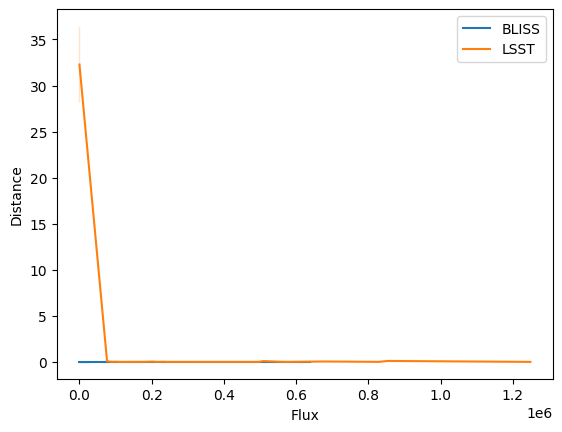

In [26]:
# Generate bin intervals
bins = np.linspace(lsst_flux_dist_df["flux"].min(), lsst_flux_dist_df["flux"].max(), num=100)
bliss_flux_dist_df["bins"] = pd.cut(bliss_flux_dist_df["flux"], bins).apply(lambda x: x.left)
lsst_flux_dist_df["bins"] = pd.cut(lsst_flux_dist_df["flux"], bins).apply(lambda x: x.left)
sns.lineplot(x=bliss_flux_dist_df["bins"], y=bliss_flux_dist_df["dist"], label="BLISS")
sns.lineplot(x=lsst_flux_dist_df["bins"], y=lsst_flux_dist_df["dist"], label="LSST")
plt.xlabel("Flux")
plt.ylabel("Distance")

In [27]:
print(len([i for i in zip(bins[:-1], bins[1:])]))
print(len(bins))

99
100


In [28]:
metrics = {"lsst_recall": [], "bliss_recall": [], "bliss_tp": [], "lsst_tp": [], "n_true": []}

true_full_id_flux_df = pd.DataFrame({'id': cur_image_true_full_catalog["objid"][0, :, 0], 
                                     "flux": normalize_flux(cur_image_true_full_catalog["galaxy_fluxes"][0, :, 2],
                                                            lsst_flux_dist_df["flux"])})

true_full_id_flux_df["p0_truth"] = cur_image_true_full_catalog["plocs"][0, :, 0]
true_full_id_flux_df["p1_truth"] = cur_image_true_full_catalog["plocs"][0, :, 1]
for i, (flux_low, flux_high) in enumerate(zip(bins[:-1], bins[1:])):
    if i != len(bins) - 1:
        sub_true_full_id_flux_df = true_full_id_flux_df.loc[(true_full_id_flux_df["flux"] >= flux_low) & \
                                                            (true_full_id_flux_df["flux"] < flux_high), :]
    else:
        sub_true_full_id_flux_df = true_full_id_flux_df.loc[(true_full_id_flux_df["flux"] >= flux_low) & \
                                                            (true_full_id_flux_df["flux"] < flux_high + 1), :]
    if len(sub_true_full_id_flux_df) == 0:
        metrics["lsst_tp"].append(0)
        metrics["lsst_recall"].append(0)
        metrics["bliss_tp"].append(0)
        metrics["bliss_recall"].append(0)
        metrics["n_true"].append(0)

        continue

    n_true = len(sub_true_full_id_flux_df)
    
    p0_truth = sub_true_full_id_flux_df["p0_truth"]
    p1_truth = sub_true_full_id_flux_df["p1_truth"]
    true_plocs = torch.tensor(np.stack((p0_truth, p1_truth), axis = -1))
    
    matched_lsst = sub_true_full_id_flux_df.merge(lsst_catalog, 
                                               left_on="id", right_on="id_truth", how="left")
    
    p0 = matched_lsst.dropna()["plocs0"]
    p1 = matched_lsst.dropna()["plocs1"]
    lsst_plocs = torch.tensor(np.stack((p0, p1), axis = -1))
    if lsst_plocs.shape[0] != 0:
        _, _, lsst_dkeep, _, _, _ = match_by_locs(true_plocs, lsst_plocs)

        lsst_tp = lsst_dkeep.sum().item()

        metrics["lsst_tp"].append(lsst_tp)
        lsst_recall = lsst_tp / n_true
        metrics["lsst_recall"].append(lsst_recall)
    else:
        metrics["lsst_tp"].append(0)
        metrics["lsst_recall"].append(0)
    
    _, _, bliss_dkeep, _, _, _ = match_by_locs(true_plocs, bliss_catalog["plocs"][0])

    bliss_tp = bliss_dkeep.sum().item()
    
    metrics["bliss_tp"].append(bliss_tp)
    bliss_recall = bliss_tp / n_true
    metrics["bliss_recall"].append(bliss_recall)
    metrics["n_true"].append(n_true)

/tmp/ipykernel_543029/2718334492.py:29: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax1.set_ylim(ylims2)


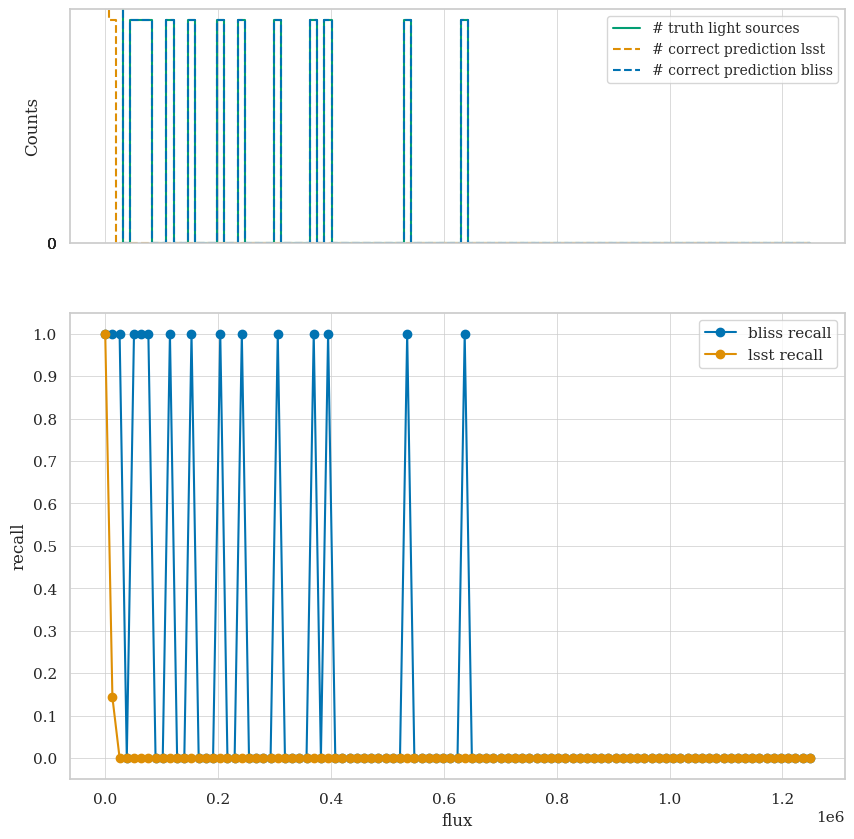

In [29]:
import seaborn as sns
sns.set_theme(style="whitegrid", palette="colorblind", font="serif")
metrics_data = pd.DataFrame(metrics, columns=["lsst_recall", "bliss_recall", 
                                              "bliss_tp", "lsst_tp", "n_true"])
ymin = metrics_data.min().min()
yticks = np.arange(np.round(ymin, 1), 1.1, 0.1)
c1 = plt.rcParams["axes.prop_cycle"].by_key()["color"][0]
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(10, 10), gridspec_kw={"height_ratios": [1, 2]}, sharex=True
)
c2 = plt.rcParams["axes.prop_cycle"].by_key()["color"][1]
ax2.plot(bins[:-1], metrics_data["bliss_recall"], "-o", color=c1, label="bliss recall", markersize=6)
ax2.plot(bins[:-1], metrics_data["lsst_recall"], "-o", color=c2, label="lsst recall", markersize=6)

ax2.legend()
ax2.set_xlabel("flux")
ax2.set_ylabel("recall")
ax2.set_yticks(yticks)
ax2.grid(linestyle="-", linewidth=0.5, which="major", axis="both")

xlims = None
ylims = None
ylims2 = 1
if xlims is not None:
    ax2.set_xlim(xlims)
if ylims is not None:
    ax2.set_ylim(ylims)
if ylims2 is not None:
    ax1.set_ylim(ylims2)

where_step = "mid"
n_ticks = 5
ordmag = 3
legend_size_hist = 10

c3 = plt.rcParams["axes.prop_cycle"].by_key()["color"][2]
ax1.step(bins[:-1], metrics_data["n_true"], label="# truth light sources", where=where_step, color=c3)
ax1.step(bins[:-1], metrics_data["lsst_tp"], label="# correct prediction lsst", ls="--", where=where_step, color=c2)
ax1.step(bins[:-1], metrics_data["bliss_tp"], label="# correct prediction bliss", ls="--", where=where_step, color=c1)
ymax = metrics_data.max().max()
yticks = np.round(np.linspace(0, ymax, n_ticks), -ordmag)
ax1.set_yticks(yticks)
ax1.set_ylabel("Counts")
ax1.legend(loc="best", prop={"size": legend_size_hist})
ax1.grid(linestyle="-", linewidth=0.5, which="major", axis="both")

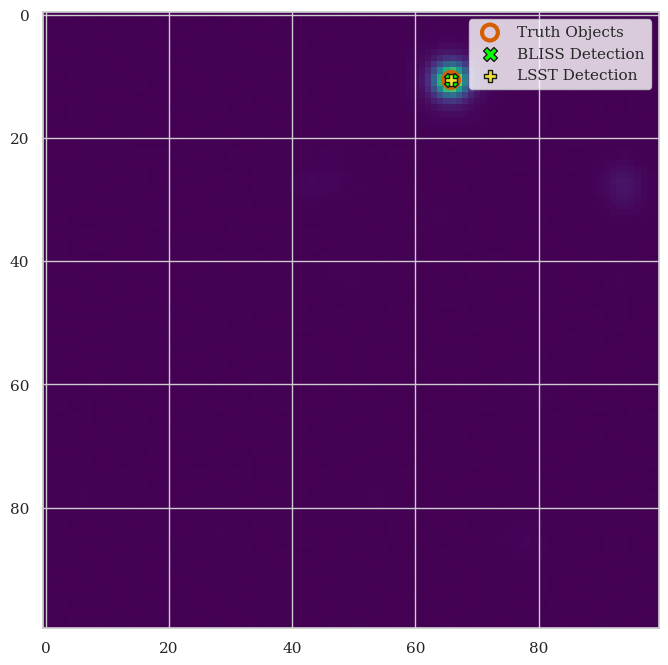

In [30]:
for i in range(5, 10):
    lim1 = i * 100
    lim2 = lim1 + 100
    true_plocs = cur_image_true_full_catalog.plocs[0]
    x0_mask = (true_plocs[:, 0] > lim1) & (true_plocs[:, 0] < lim2)
    x1_mask = (true_plocs[:, 1] > lim1) & (true_plocs[:, 1] < lim2)
    x_mask_true = x0_mask * x1_mask

    bliss_plocs = bliss_catalog.plocs[0]
    x0_mask = (bliss_plocs[:, 1] > lim1) & (bliss_plocs[:, 1] < lim2)
    x1_mask = (bliss_plocs[:, 0] > lim1) & (bliss_plocs[:, 0] < lim2)
    x_mask_bliss = x0_mask * x1_mask

    # run our matching algorithm (instead of using lsst's matching)
    if true_plocs[x_mask_true].shape[0] == 0:
        continue
    
    lsst_plocs = torch.stack([torch.tensor(lsst_catalog["plocs0"].to_numpy()), 
                              torch.tensor(lsst_catalog["plocs1"].to_numpy())], dim=-1)
    row_lsst, col_lsst, lsst_dkeep, avg_distance, avg_keep_distance, lsst_dist = match_by_locs(
        true_plocs[x_mask_true], lsst_plocs)
    lsst_plocs = lsst_plocs[col_lsst][lsst_dkeep]
    x0_mask = (lsst_plocs[:, 1] > lim1) & (lsst_plocs[:, 1] < lim2)
    x1_mask = (lsst_plocs[:, 0] > lim1) & (lsst_plocs[:, 0] < lim2)
    x_mask_lsst = x0_mask * x1_mask

    fig,ax = plt.subplots(figsize=(8, 8))
    image = dc2.dc2_data[0]["images"][0]
    image_small = image[lim1:lim2, lim1:lim2]
    ax.imshow(np.log((image_small - image_small.min()) + 80), cmap="viridis")
    ax.scatter(true_plocs[:, 1][x_mask_true] - lim1, true_plocs[:, 0][x_mask_true] - lim1, 
               facecolors="none", edgecolors="r", 
               alpha=1, s=130, linewidth=3, label="Truth Objects")
    ax.scatter(bliss_plocs[:, 1][x_mask_bliss] - lim1, bliss_plocs[:, 0][x_mask_bliss] - lim1, 
               marker="X", facecolors="lime", edgecolors="k", 
               alpha=1, s=100, linewidth=1, label="BLISS Detection")
    ax.scatter(lsst_plocs[:, 1][x_mask_lsst] - lim1, lsst_plocs[:, 0][x_mask_lsst] - lim1, 
               marker="P", facecolors="y", edgecolors="k", 
               alpha=1, s=80, linewidth=1, label="LSST Detection")

    ax.legend()

In [31]:
# Galaxy error plots
true_matches, bliss_matches = matching[0]
true_galaxy_params = cur_image_true_full_catalog["galaxy_params"][0, true_matches, :]
bliss_galaxy_params = bliss_catalog["galaxy_params"][0, bliss_matches, :]
galaxy_params_err = true_galaxy_params - bliss_galaxy_params
err_df = pd.DataFrame({
                    "flux": cur_image_true_full_catalog["galaxy_fluxes"][0, true_matches, :][:, 2],
                    "disk_frac":galaxy_params_err[:, 0],
                    "beta_radians":galaxy_params_err[:, 1],
                    "disk_q":galaxy_params_err[:, 2],
                    "a_d":galaxy_params_err[:, 3],
                    "bulge_q":galaxy_params_err[:, 4],
                    "a_b":galaxy_params_err[:, 5]})

Text(0, 0.5, 'beta_radians')

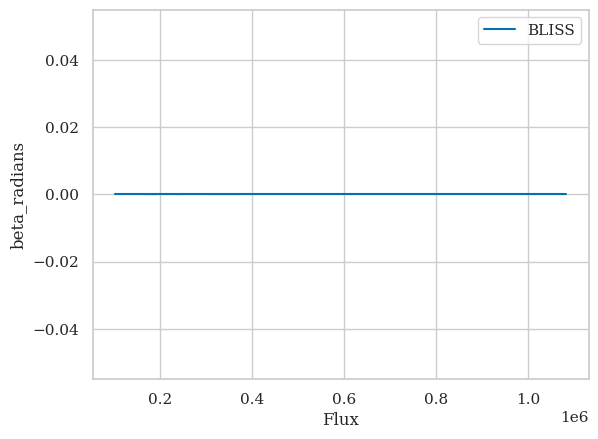

In [32]:
err_df["bins"] = pd.cut(err_df["flux"], bins).apply(lambda x: x.left)
sns.lineplot(x=err_df["bins"], y=abs(err_df["beta_radians"]), label="BLISS")
plt.xlabel("Flux")
plt.ylabel("beta_radians")

Text(0, 0.5, 'a_d')

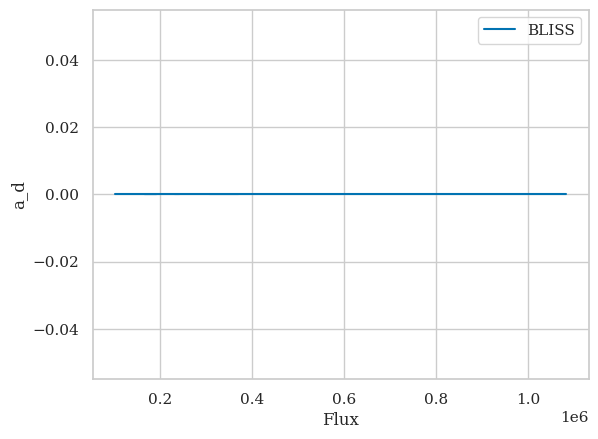

In [33]:
err_df["bins"] = pd.cut(err_df["flux"], bins).apply(lambda x: x.left)
sns.lineplot(x=err_df["bins"], y=abs(err_df["a_d"]), label = "BLISS")
plt.xlabel("Flux")
plt.ylabel("a_d")

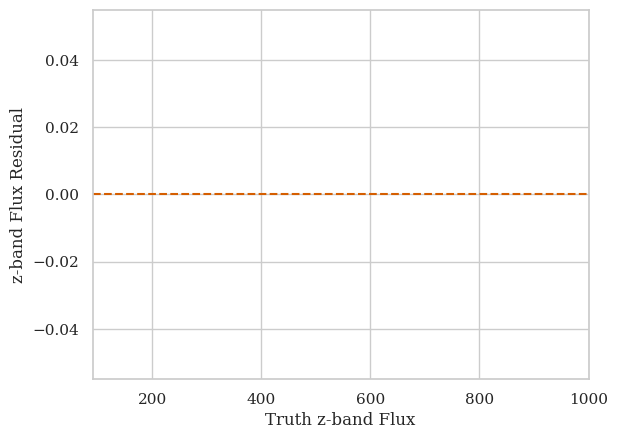

In [34]:
# flux error
true_flux = cur_image_true_full_catalog.on_fluxes[0, true_matches, :]
bliss_flux = bliss_catalog.on_fluxes[0, bliss_matches, :]
flux_err = true_flux - bliss_flux
est_band_flux = bliss_flux[:, 2]
true_band_flux = true_flux[:, 2]
res = flux_err[:, 2] / true_band_flux
sns.scatterplot(
    x = np.array(true_band_flux), 
    y = np.array(res), 
    alpha = 0.6,
    c = np.log(true_flux[:, 2]), 
    cmap = "viridis"
)
plt.xlim(90, 1000)
plt.ylabel('z-band Flux Residual')
plt.xlabel('Truth z-band Flux')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()